<a href="https://colab.research.google.com/github/amanjain487/panoptic-segmentation-using-DETR/blob/main/Visualize_Panoptic_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize Panoptic Predictions

# INPUTS

In [ ]:
weights_file_path = ""  # - keep it empty if u have uploaded file directly in base of your drive .... but if u have uploaded in some other folder, please provide path of that folder
img_url = "https://images.globest.com/contrib/content/uploads/sites/304/2020/04/Construction-resized.jpg"

## Install Detectron2 (Panoptic Visualization Utility)

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime


# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version


# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=327ee3ce474f5b6cd581053a2f960d1c5b89bb72908f097c0933ce55ec420e11
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 3.0 kB/s 
     |████████████████████████████████| 22.1 MB 6.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:

1.9.0+cu102 True


## Get CUDA Device Properties

In [ ]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Mount Google Drive

- Fetch Images
- Fetch model weights
- Save predictions


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Install Required Libraries/Packages

In [ ]:
# install panopticapi package
! pip install git+https://github.com/cocodataset/panopticapi.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-kjzg_x_a
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-kjzg_x_a
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=0918c21ed6dd8e1f1ce9556ed63fa781cf86a8445c2f382a3f0faeb985d5f8bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ohz2rom/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


## Import Libraries


In [ ]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy


# These are the COCO classes
CLASSES = ['misc', 'textile', 'building', 'rawmaterial', 'furniture', 'floor', 'plant', 'food', 'ground', 'structural', 'water', 'wall', 'window', 'ceiling', 'sky', 'solid', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck_tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader', 'smoke_detectors', 'split_units', 'structural_steel_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer']


# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Necessary Scripts
- Provided by DETR

In [ ]:
from torch import nn
from typing import Optional
from torch import Tensor
import torchvision
import torch.distributed as dist
from torchvision.models._utils import IntermediateLayerGetter
from typing import Dict, List


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()

def is_main_process():
    return get_rank() == 0

class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        return out


class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias

        
class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=is_main_process(), norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos

In [ ]:
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


@torch.jit.unused
def _onnx_nested_tensor_from_tensor_list(tensor_list: List[Tensor]) -> NestedTensor:
    max_size = []
    for i in range(tensor_list[0].dim()):
        max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
        max_size.append(max_size_i)
    max_size = tuple(max_size)

    # work around for
    # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    # m[: img.shape[1], :img.shape[2]] = False
    # which is not yet supported in onnx
    padded_imgs = []
    padded_masks = []
    for img in tensor_list:
        padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_imgs.append(padded_img)

        m = torch.zeros_like(img[0], dtype=torch.int, device=img.device)
        padded_mask = torch.nn.functional.pad(m, (0, padding[2], 0, padding[1]), "constant", 1)
        padded_masks.append(padded_mask.to(torch.bool))

    tensor = torch.stack(padded_imgs)
    mask = torch.stack(padded_masks)

    return NestedTensor(tensor, mask=mask)

def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        if torchvision._is_tracing():
            # nested_tensor_from_tensor_list() does not export well to ONNX
            # call _onnx_nested_tensor_from_tensor_list() instead
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)


class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]


class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results

In [ ]:
import math

class PositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [ ]:
from collections import defaultdict
import torchvision
if float(torchvision.__version__.split(".")[1]) < 7.0:
    from torchvision.ops import _new_empty_tensor
    from torchvision.ops.misc import _output_size

def interpolate(input, size=None, scale_factor=None, mode="nearest", align_corners=None):
    # type: (Tensor, Optional[List[int]], Optional[float], str, Optional[bool]) -> Tensor
    """
    Equivalent to nn.functional.interpolate, but with support for empty batch sizes.
    This will eventually be supported natively by PyTorch, and this
    class can go away.
    """
    if float(torchvision.__version__.split(".")[1]) < 7.0:
        if input.numel() > 0:
            return torch.nn.functional.interpolate(
                input, size, scale_factor, mode, align_corners
            )

        output_shape = _output_size(2, input, size, scale_factor)
        output_shape = list(input.shape[:-2]) + list(output_shape)
        return _new_empty_tensor(input, output_shape)
    else:
        return torchvision.ops.misc.interpolate(input, size, scale_factor, mode, align_corners)

def _expand(tensor, length: int):
    return tensor.unsqueeze(1).repeat(1, int(length), 1, 1, 1).flatten(0, 1)

class MaskHeadSmallConv(nn.Module):
    """
    Simple convolutional head, using group norm.
    Upsampling is done using a FPN approach
    """

    def __init__(self, dim, fpn_dims, context_dim):
        super().__init__()

        inter_dims = [dim, context_dim // 2, context_dim // 4, context_dim // 8, context_dim // 16, context_dim // 64]
        self.lay1 = torch.nn.Conv2d(dim, dim, 3, padding=1)
        self.gn1 = torch.nn.GroupNorm(8, dim)
        self.lay2 = torch.nn.Conv2d(dim, inter_dims[1], 3, padding=1)
        self.gn2 = torch.nn.GroupNorm(8, inter_dims[1])
        self.lay3 = torch.nn.Conv2d(inter_dims[1], inter_dims[2], 3, padding=1)
        self.gn3 = torch.nn.GroupNorm(8, inter_dims[2])
        self.lay4 = torch.nn.Conv2d(inter_dims[2], inter_dims[3], 3, padding=1)
        self.gn4 = torch.nn.GroupNorm(8, inter_dims[3])
        self.lay5 = torch.nn.Conv2d(inter_dims[3], inter_dims[4], 3, padding=1)
        self.gn5 = torch.nn.GroupNorm(8, inter_dims[4])
        self.out_lay = torch.nn.Conv2d(inter_dims[4], 1, 3, padding=1)

        self.dim = dim

        self.adapter1 = torch.nn.Conv2d(fpn_dims[0], inter_dims[1], 1)
        self.adapter2 = torch.nn.Conv2d(fpn_dims[1], inter_dims[2], 1)
        self.adapter3 = torch.nn.Conv2d(fpn_dims[2], inter_dims[3], 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor, bbox_mask: Tensor, fpns: List[Tensor]):
        x = torch.cat([_expand(x, bbox_mask.shape[1]), bbox_mask.flatten(0, 1)], 1)

        x = self.lay1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.lay2(x)
        x = self.gn2(x)
        x = F.relu(x)

        cur_fpn = self.adapter1(fpns[0])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay3(x)
        x = self.gn3(x)
        x = F.relu(x)

        cur_fpn = self.adapter2(fpns[1])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay4(x)
        x = self.gn4(x)
        x = F.relu(x)

        cur_fpn = self.adapter3(fpns[2])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay5(x)
        x = self.gn5(x)
        x = F.relu(x)

        x = self.out_lay(x)
        return x


class MHAttentionMap(nn.Module):
    """This is a 2D attention module, which only returns the attention softmax (no multiplication by value)"""

    def __init__(self, query_dim, hidden_dim, num_heads, dropout=0.0, bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.q_linear = nn.Linear(query_dim, hidden_dim, bias=bias)
        self.k_linear = nn.Linear(query_dim, hidden_dim, bias=bias)

        nn.init.zeros_(self.k_linear.bias)
        nn.init.zeros_(self.q_linear.bias)
        nn.init.xavier_uniform_(self.k_linear.weight)
        nn.init.xavier_uniform_(self.q_linear.weight)
        self.normalize_fact = float(hidden_dim / self.num_heads) ** -0.5

    def forward(self, q, k, mask: Optional[Tensor] = None):
        q = self.q_linear(q)
        k = F.conv2d(k, self.k_linear.weight.unsqueeze(-1).unsqueeze(-1), self.k_linear.bias)
        qh = q.view(q.shape[0], q.shape[1], self.num_heads, self.hidden_dim // self.num_heads)
        kh = k.view(k.shape[0], self.num_heads, self.hidden_dim // self.num_heads, k.shape[-2], k.shape[-1])
        weights = torch.einsum("bqnc,bnchw->bqnhw", qh * self.normalize_fact, kh)

        if mask is not None:
            weights.masked_fill_(mask.unsqueeze(1).unsqueeze(1), float("-inf"))
        weights = F.softmax(weights.flatten(2), dim=-1).view(weights.size())
        weights = self.dropout(weights)
        return weights

class DETRsegm(nn.Module):
    def __init__(self, detr, freeze_detr=False):
        super().__init__()
        self.detr = detr

        if freeze_detr:
            for p in self.parameters():
                p.requires_grad_(False)

        hidden_dim, nheads = detr.transformer.d_model, detr.transformer.nhead
        self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
        self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)

    def forward(self, samples: NestedTensor):
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.detr.backbone(samples)

        bs = features[-1].tensors.shape[0]

        src, mask = features[-1].decompose()
        assert mask is not None
        src_proj = self.detr.input_proj(src)
        hs, memory = self.detr.transformer(src_proj, mask, self.detr.query_embed.weight, pos[-1])

        outputs_class = self.detr.class_embed(hs)
        outputs_coord = self.detr.bbox_embed(hs).sigmoid()
        out = {"pred_logits": outputs_class[-1], "pred_boxes": outputs_coord[-1]}
        if self.detr.aux_loss:
            out['aux_outputs'] = self.detr._set_aux_loss(outputs_class, outputs_coord)

        # FIXME h_boxes takes the last one computed, keep this in mind
        bbox_mask = self.bbox_attention(hs[-1], memory, mask=mask)

        seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        outputs_seg_masks = seg_masks.view(bs, self.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])

        out["pred_masks"] = outputs_seg_masks
        return out

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

class PostProcessPanoptic(nn.Module):
    """This class converts the output of the model to the final panoptic result, in the format expected by the
    coco panoptic API """

    def __init__(self, is_thing_map, threshold=0.85):
        """
        Parameters:
           is_thing_map: This is a whose keys are the class ids, and the values a boolean indicating whether
                          the class is  a thing (True) or a stuff (False) class
           threshold: confidence threshold: segments with confidence lower than this will be deleted
        """
        super().__init__()
        self.threshold = threshold
        self.is_thing_map = is_thing_map

    def forward(self, outputs, processed_sizes, target_sizes=None):
        """ This function computes the panoptic prediction from the model's predictions.
        Parameters:
            outputs: This is a dict coming directly from the model. See the model doc for the content.
            processed_sizes: This is a list of tuples (or torch tensors) of sizes of the images that were passed to the
                             model, ie the size after data augmentation but before batching.
            target_sizes: This is a list of tuples (or torch tensors) corresponding to the requested final size
                          of each prediction. If left to None, it will default to the processed_sizes
            """
        if target_sizes is None:
            target_sizes = processed_sizes
        assert len(processed_sizes) == len(target_sizes)
        out_logits, raw_masks, raw_boxes = outputs["pred_logits"], outputs["pred_masks"], outputs["pred_boxes"]
        assert len(out_logits) == len(raw_masks) == len(target_sizes)
        preds = []

        def to_tuple(tup):
            if isinstance(tup, tuple):
                return tup
            return tuple(tup.cpu().tolist())

        for cur_logits, cur_masks, cur_boxes, size, target_size in zip(
            out_logits, raw_masks, raw_boxes, processed_sizes, target_sizes
        ):
            # we filter empty queries and detection below threshold
            scores, labels = cur_logits.softmax(-1).max(-1)
            keep = labels.ne(outputs["pred_logits"].shape[-1] - 1) & (scores > self.threshold)
            cur_scores, cur_classes = cur_logits.softmax(-1).max(-1)
            cur_scores = cur_scores[keep]
            cur_classes = cur_classes[keep]
            cur_masks = cur_masks[keep]
            cur_masks = interpolate(cur_masks[:, None], to_tuple(size), mode="bilinear").squeeze(1)
            cur_boxes = box_cxcywh_to_xyxy(cur_boxes[keep])

            h, w = cur_masks.shape[-2:]
            assert len(cur_boxes) == len(cur_classes)

            # It may be that we have several predicted masks for the same stuff class.
            # In the following, we track the list of masks ids for each stuff class (they are merged later on)
            cur_masks = cur_masks.flatten(1)
            stuff_equiv_classes = defaultdict(lambda: [])
            for k, label in enumerate(cur_classes):
                if not self.is_thing_map[label.item()]:
                    stuff_equiv_classes[label.item()].append(k)

            def get_ids_area(masks, scores, dedup=False):
                # This helper function creates the final panoptic segmentation image
                # It also returns the area of the masks that appears on the image

                m_id = masks.transpose(0, 1).softmax(-1)

                if m_id.shape[-1] == 0:
                    # We didn't detect any mask :(
                    m_id = torch.zeros((h, w), dtype=torch.long, device=m_id.device)
                else:
                    m_id = m_id.argmax(-1).view(h, w)

                if dedup:
                    # Merge the masks corresponding to the same stuff class
                    for equiv in stuff_equiv_classes.values():
                        if len(equiv) > 1:
                            for eq_id in equiv:
                                m_id.masked_fill_(m_id.eq(eq_id), equiv[0])

                final_h, final_w = to_tuple(target_size)

                seg_img = Image.fromarray(id2rgb(m_id.view(h, w).cpu().numpy()))
                seg_img = seg_img.resize(size=(final_w, final_h), resample=Image.NEAREST)

                np_seg_img = (
                    torch.ByteTensor(torch.ByteStorage.from_buffer(seg_img.tobytes())).view(final_h, final_w, 3).numpy()
                )
                m_id = torch.from_numpy(rgb2id(np_seg_img))

                area = []
                for i in range(len(scores)):
                    area.append(m_id.eq(i).sum().item())
                return area, seg_img

            area, seg_img = get_ids_area(cur_masks, cur_scores, dedup=True)
            if cur_classes.numel() > 0:
                # We know filter empty masks as long as we find some
                while True:
                    filtered_small = torch.as_tensor(
                        [area[i] <= 4 for i, c in enumerate(cur_classes)], dtype=torch.bool, device=keep.device
                    )
                    if filtered_small.any().item():
                        cur_scores = cur_scores[~filtered_small]
                        cur_classes = cur_classes[~filtered_small]
                        cur_masks = cur_masks[~filtered_small]
                        area, seg_img = get_ids_area(cur_masks, cur_scores)
                    else:
                        break

            else:
                cur_classes = torch.ones(1, dtype=torch.long, device=cur_classes.device)

            segments_info = []
            for i, a in enumerate(area):
                cat = cur_classes[i].item()
                segments_info.append({"id": i, "isthing": self.is_thing_map[cat], "category_id": cat, "area": a})
            del cur_classes

            with io.BytesIO() as out:
                seg_img.save(out, format="PNG")
                predictions = {"png_string": out.getvalue(), "segments_info": segments_info}
            preds.append(predictions)
        return preds

In [ ]:
import torch.nn.functional as F
import copy


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")

class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src

        for layer in self.layers:
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self, src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self, tgt, memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None,
                    query_pos: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt2, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)





class Transformer(nn.Module):

    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec)

        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        hs = self.decoder(tgt, memory, memory_key_padding_mask=mask,
                          pos=pos_embed, query_pos=query_embed)
        return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)

## Load Trained Model Weights

In [ ]:
os.chdir("/content/drive/MyDrive/" + weights_file_path)

dependencies = ["torch", "torchvision"]

# build the detr model
def _make_detr(backbone_name: str, dilation=False, num_classes=91, mask=False):
    hidden_dim = 256
    backbone = Backbone(backbone_name, train_backbone=True, return_interm_layers=mask, dilation=dilation)
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True)
    detr = DETR(backbone_with_pos_enc, transformer, num_classes=num_classes, num_queries=25)
    if mask:
        return DETRsegm(detr)
    return detr

# use resnet50 as backbone
model = _make_detr("resnet50", dilation=False, num_classes=250, mask=True)
is_thing_map = {i: i <= 90 for i in range(250)}

checkpoint = torch.load("checkpoint0044.pth", map_location='cpu')

model.load_state_dict(checkpoint["model"])

model, postprocessor = model, PostProcessPanoptic(is_thing_map, threshold=0.75)
model.eval()

DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      

## Utility Function to Display Ground Truth

In [ ]:
import numpy as np
import cv2
from math import floor
import random

def superimpose_thing(image, image_size, annotation):
    height, width = image_size

    # create a single channel black image
    overlay = np.zeros((height, width, 3), dtype=np.uint8)
    color = (random.randint(150, 255), random.randint(0, 150), random.randint(100, 205))
    polygons_list = []
    # Add the polygon segmentation
    for segmentation_points in annotation['segmentation']:
        segmentation_points = np.multiply(segmentation_points, 1).astype(int)
        polygons_list.append(segmentation_points)

    # convert segmentation points to contour
    for x in polygons_list:
        end = []
        if len(x) % 2 != 0:
            print(x)
        for l in range(0, len(x), 2):
            coords = [floor(x[l]), floor(x[l + 1])]
            end.append(coords)
        contours = np.array(end)
        if end == []:
            continue

        # plot and fill the contour
        cv2.fillPoly(overlay, pts=[contours], color=color)
    cv2.addWeighted(image, 1, overlay, 0.8, 0, image)
    return image

## Create Detectron MetaCatalog

In [ ]:
import os
import json
import random
import itertools
import seaborn as sns
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow
import cv2

palette = itertools.cycle(sns.color_palette())

from copy import deepcopy


# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("construction_panoptic")

meta.set(evaluator_type = 'coco_panoptic_seg', ignore_label = 255, image_root = 'detr/datasets/images', json_file = 'detr/datasets/combined.json', name = 'construction_panoptic', panoptic_json = 'detr/datasets/combined.json', panoptic_root = 'detr/datasets')
meta.set(thing_classes = ['N/A', 'misc', 'textile', 'building', 'rawmaterial', 'furniture', 'floor', 'plant', 'food', 'ground', 'structural', 'water', 'wall', 'window', 'ceiling', 'sky', 'solid', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck_tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader', 'smoke_detectors', 'split_units', 'structural_steel_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer'])
meta.set(thing_dataset_id_to_contiguous_id={i:i for i in range(65)})
meta.set(stuff_classes = ['N/A', 'misc', 'textile', 'building', 'rawmaterial', 'furniture', 'floor', 'plant', 'food', 'ground', 'structural', 'water', 'wall', 'window', 'ceiling', 'sky', 'solid', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck_tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader', 'smoke_detectors', 'split_units', 'structural_steel_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer'])
meta.set(stuff_dataset_id_to_contiguous_id = {i:i for i in range(65)})


Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='detr/datasets/images', json_file='detr/datasets/combined.json', name='construction_panoptic', panoptic_json='detr/datasets/combined.json', panoptic_root='detr/datasets', stuff_classes=['N/A', 'misc', 'textile', 'building', 'rawmaterial', 'furniture', 'floor', 'plant', 'food', 'ground', 'structural', 'water', 'wall', 'window', 'ceiling', 'sky', 'solid', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck_tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_u

## Save Panoptic Predictions

- Clear output after 25 predictions

In [ ]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import io
# from IPython.display import clear_output 

# os.chdir("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/")
# os.makedirs("/content/drive/MyDrive/Panoptic Segmentation using DETR/Submission Files/panoptic_predictions", exist_ok=True)

# f = open("val.json")
# j = json.load(f)
# f.close()

# images = j["images"]
# random.shuffle(images)

# count = 0

# for image_dict in images:
#     if count % 25 == 0:
#         # break
#         clear_output()
#     fig = plt.figure(figsize=(36, 12))
#     ax1 = fig.add_subplot(131)
#     ax2 = fig.add_subplot(132)
#     ax3 = fig.add_subplot(133)
#     ax1.title.set_text('Original Image')
#     ax2.title.set_text('Ground Truth')
#     ax3.title.set_text('Panoptic Prediction')

#     image_name = image_dict["file_name"]
#     im = Image.open("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/train/" + image_name)
#     ax1.imshow(im)
#     plt.axis("off")
#     image_id = None
#     for x in j["images"]:
#       if x["file_name"] == image_name:
#         image_id = x["id"]
#         break

#     stuff_annotation = []
#     thing_annotation = []

#     for x in j["annotations"]:
#       if x["image_id"] == image_id:
#         if x["category_id"] < 17:
#           stuff_annotation.append(x)
#         else:
#           thing_annotation.append(x)

#     stuff_annotation = sorted(stuff_annotation, key=lambda i:i["area"], reverse=True)
#     thing_annotation = sorted(thing_annotation, key=lambda i:i["area"], reverse=True)


#     img = cv2.imread("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/train/" + image_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = np.zeros(img.shape, dtype=np.uint8)

#     image_size = img.shape[:2]
#     for x in stuff_annotation:
#       img = superimpose_thing(img, image_size, x)
#     for x in thing_annotation:
#       img = superimpose_thing(img, image_size, x)

#     ground_truth = img.copy()
#     ax2.imshow(img)
#     plt.axis("off")
#     # mean-std normalize the input image (batch-size: 1)
#     img = transform(im).unsqueeze(0)
#     out = model(img)

#     # the post-processor expects as input the target size of the predictions (which we set here to the image size)
#     result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

#     # The segmentation is stored in a special-format png
#     panoptic_seg = Image.open(io.BytesIO(result['png_string']))
#     panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
#     # We retrieve the ids corresponding to each mask
#     panoptic_seg_id = rgb2id(panoptic_seg)

#     # Finally we color each mask individually
#     panoptic_seg[:, :, :] = 0
#     for id in range(panoptic_seg_id.max() + 1):
#       panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
#     mapping = {}
#     for x in result['segments_info']:
#       if x["category_id"] < 17:
#         if x["category_id"] not in mapping:
#           mapping[x["category_id"]] = x["id"]
#         else:
#           x["id"] = mapping[x["category_id"]]


#     # We extract the segments info and the panoptic result from DETR's prediction
#     segments_info = deepcopy(result["segments_info"])
#     # Panoptic predictions are stored in a special format png
#     panoptic_seg = Image.open(io.BytesIO(result['png_string']))
#     final_w, final_h = panoptic_seg.size
#     # We convert the png into an segment id map
#     panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
#     panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))
#     palette = itertools.cycle(sns.color_palette())

#     for i in range(len(segments_info)):
#         c = segments_info[i]["category_id"]
#         # segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

#     # Finally we visualize the prediction
#     v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
#     v._default_font_size = 20
#     v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
#     ax3.imshow(v.get_image())
#     plt.axis("off")
#     plt.savefig("/content/drive/MyDrive/Panoptic Segmentation using DETR/Submission Files/panoptic_predictions/" + image_name, bbox_inches='tight')
#     plt.show()
#     count += 1
#     print(count)

# Visualize Panoptic Predictions from URL

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


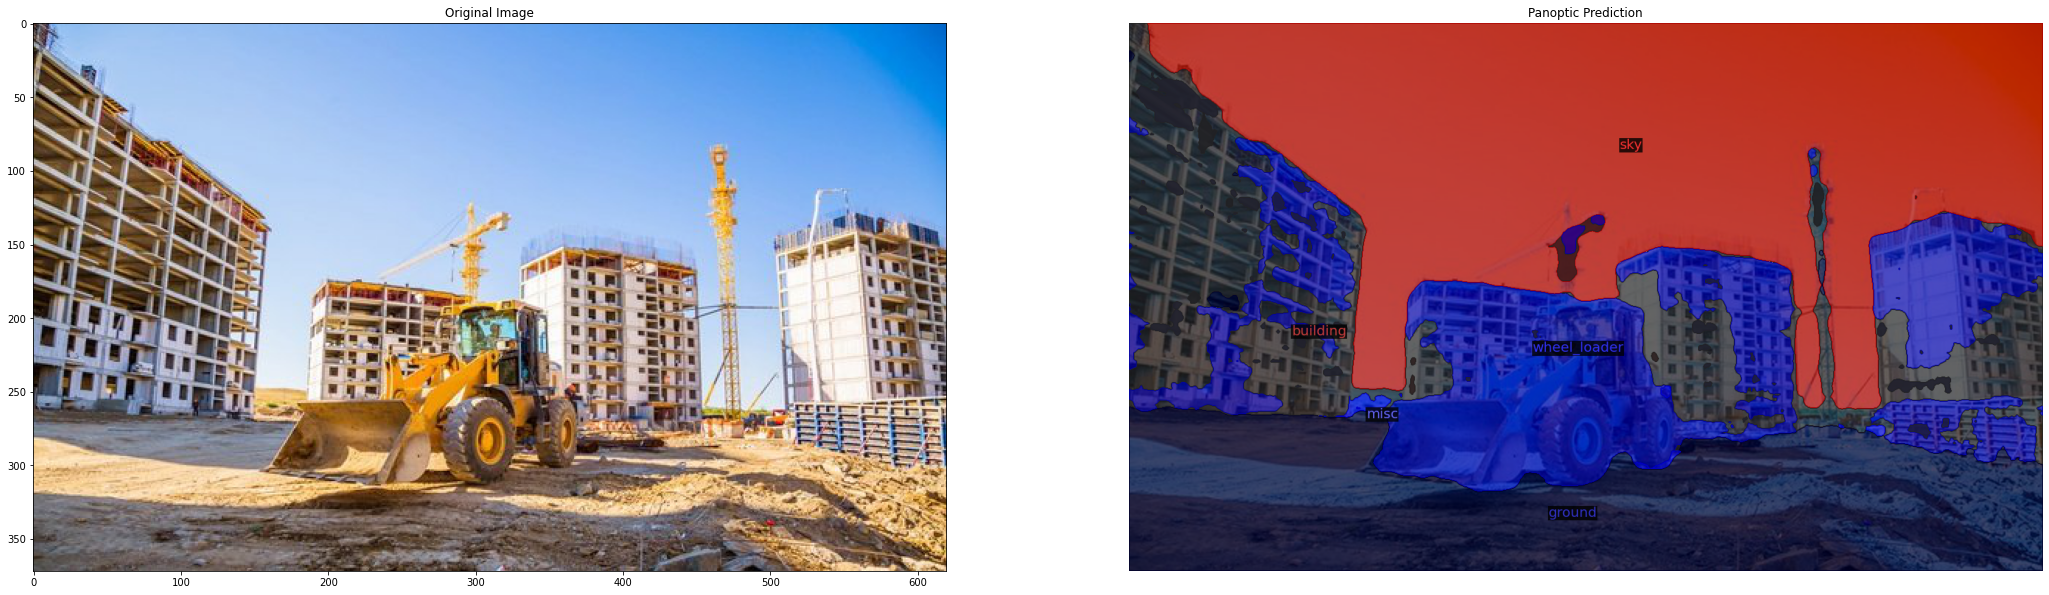

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import io
from IPython.display import clear_output 


import numpy as np
import requests
imageBinaryBytes = requests.get(img_url).content

import io
from PIL import Image

imageStream = io.BytesIO(imageBinaryBytes)
im = Image.open(imageStream)

fig = plt.figure(figsize=(36, 12))
ax1 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
ax1.title.set_text('Original Image')
ax3.title.set_text('Panoptic Prediction')

ax1.imshow(im)
plt.axis("off")

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
mapping = {}
for x in result['segments_info']:
  if x["category_id"] < 17:
    if x["category_id"] not in mapping:
      mapping[x["category_id"]] = x["id"]
    else:
      x["id"] = mapping[x["category_id"]]


# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))
palette = itertools.cycle(sns.color_palette())

for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    # segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
ax3.imshow(v.get_image())
plt.axis("off")
plt.show()
